# Reading and plotting multiple Datasets

In this notebook we will look at plotting multiple Time series from more than one dataset. Again we need the necessary imports.

In [1]:
import os
from datetime import datetime
import pandas as pd

from datascience.read import Era5, Era5Land, AscatDataH121, Gldas, read_multiple_ds
from datascience.plot import plot_multiple_gpis, plot_ts

%matplotlib widget

ERROR 1: PROJ: proj_create_from_database: Open of /home/oscipal/my_conda/share/proj failed


In this example we will look at plotting ERA-5 data with ASCAT data. You first need to create the respective objects.

In [2]:
era5 = Era5(read_bulk = False)
ascat = AscatDataH121(read_bulk = False)
era5land = Era5Land(read_bulk = False)
gldas = Gldas(read_bulk = False)

And define a lat and lon:

In [3]:
lat = 48.198905
lon = 16.367182

You can see the gpi locations and spatial resolutions differ by dataset. You can choose between 1 and 4 objects to be plotted with the *plot_mulitple_gpis* function. The closest gpis are highlighted. You can choose how many grid points you want to show per dataset.

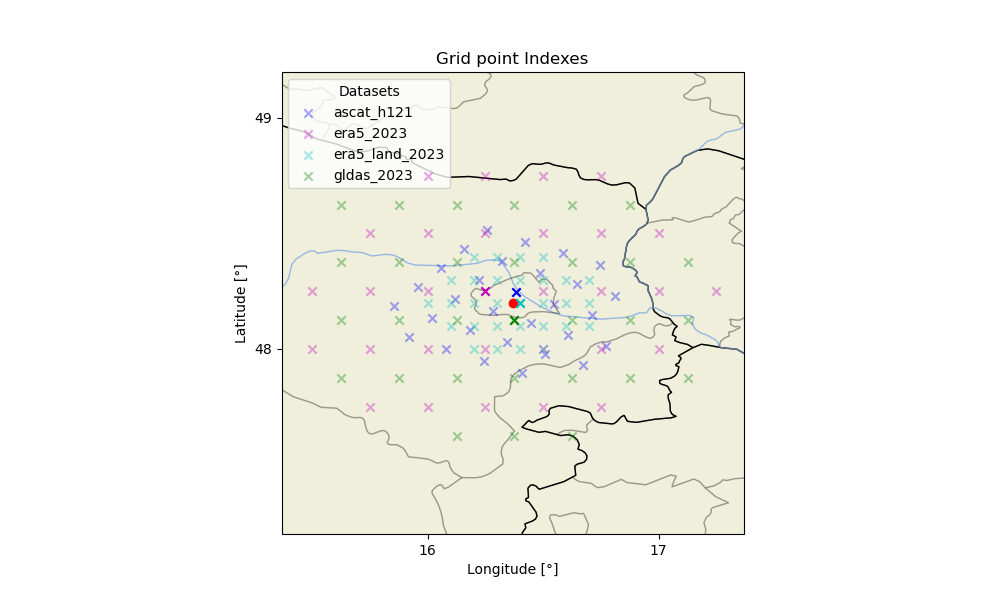

In [4]:
plot_multiple_gpis((lon, lat), ascat, era5, era5land, gldas, k=30)

To read multiple datasets and make them comparable you first need to define a location. As you can see from the plot above, the location of the gpis vary by dataset. To make the results comparable we will choose the closest grid point to the defined location for each dataset with the *grid.find_nearest_gpi()* function. This function returns the closest gpi and the distance to the location.

To keep it simple we will only load ASCAT and Era5 data in this example.

In [5]:
ascat_gpi, ascat_distance = ascat.grid.find_nearest_gpi(lon, lat)
era5_gpi, era5_distance = era5.grid.find_nearest_gpi(lon, lat)
print(f"Ascat gpi: {ascat_gpi}, distance: {ascat_distance}\nEra5 gpi: {era5_gpi}, distance: {era5_distance}")

Ascat gpi: 1227274, distance: 5527.400356838024
Era5 gpi: 240545, distance: 10396.478756964896


If you want to load the directly with the gpi, you first have to get the coordinates of the gpi using the *grid.gpi2lonlat()* function. Lets say you chose the gpi #1227274 from the ascat dataset:

In [6]:
location = ascat.grid.gpi2lonlat(ascat_gpi)
location

(16.383253, 48.24744)

Now you can get the closest Era5-gpi to the ascat gpi:

In [7]:
era5_gpi, era5_distance = era5.grid.find_nearest_gpi(location[0], location[1])
print(f"Era5 gpi: {era5_gpi}, distance: {era5_distance}")

Era5 gpi: 240546, distance: 8674.928861443408


You can now read the data:

In [8]:
ascat_data = ascat.read(ascat_gpi)
era5_data = era5.read(era5_gpi)

To merge the data you first need to make sure that the index of the dataframe is in the same format:

In [9]:
ascat_data.index = ascat_data.index.astype('datetime64[ms]')
era5_data.index = era5_data.index.astype('datetime64[ms]')

You can now merge the data using *pd.merge_asof*. Note that the resulting timestamps will be chosen from the first dataset which is given in the function, which means that information might get lost, or is chosen from the closest available timestamp.

In [10]:
merged_data = pd.merge_asof(ascat_data,
                       era5_data,
                       left_index=True,
                       right_index=True,
                       tolerance=pd.Timedelta("3h"),
                       direction="nearest")

merged_data

,as_des_pass,swath_indicator,surface_soil_moisture,surface_soil_moisture_noise,backscatter40,slope40,curvature40,surface_soil_moisture_sensitivity,backscatter_flag,correction_flag,...,frozen_soil_probability,wetland_fraction,topographic_complexity,subsurface_scattering_probability,sat_id,sd,swvl1,stl1,t2m,tp
2007-01-01 19:24:42.814,0,0,71.779999,6.72,-7.349617,-0.091480,0.000601,2.933993,7,0.0,...,53,0,5,NaN,3,0.0,0.300715,1.744720,9.554047,-1.862645e-09
2007-01-02 09:18:14.356,1,0,NaN,NaN,NaN,NaN,NaN,NaN,2,1.0,...,43,0,5,NaN,3,0.0,0.297786,3.246307,5.077179,-1.862645e-09
2007-01-02 19:04:06.049,0,0,55.860001,6.75,-7.870332,-0.091474,0.000609,2.936791,7,0.0,...,43,0,5,NaN,3,0.0,0.298124,3.455261,3.780670,2.891198e-05
2007-01-03 20:23:28.700,0,1,48.869999,6.73,-8.100801,-0.091527,0.000615,2.939877,7,0.0,...,36,0,5,NaN,3,0.0,0.301197,4.839661,5.298035,-1.862645e-09
2007-01-04 08:36:49.040,1,1,60.529999,6.68,-7.724965,-0.091705,0.000628,2.947791,7,0.0,...,43,0,5,NaN,3,0.0,0.300305,3.321045,3.870300,6.424822e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-30 09:26:54.144,1,0,NaN,NaN,-7.370146,-0.098986,0.000859,2.884198,3,0.0,...,41,0,5,NaN,4,NaN,NaN,NaN,NaN,NaN
2024-01-30 19:12:45.852,0,0,82.360001,6.95,-6.871718,-0.098986,0.000859,2.884198,7,0.0,...,41,0,5,NaN,4,NaN,NaN,NaN,NaN,NaN
2024-01-30 20:05:35.610,0,1,NaN,NaN,-7.476925,-0.098986,0.000859,2.884198,3,0.0,...,41,0,5,NaN,5,NaN,NaN,NaN,NaN,NaN
2024-01-31 08:18:52.567,1,1,NaN,NaN,NaN,NaN,NaN,NaN,2,1.0,...,43,0,5,NaN,5,NaN,NaN,NaN,NaN,NaN


With the *read_multiple_ds* function you can read multiple datasets simultaneously. For the parameter *loc* you can either choose a (lon,lat) location or a gpi, you can choose one or more datasets to be read, but note that you need to choose a reference dataset (either *"ascat", "era5", "era5land"* or *"gldas"*). If you give a gpi for the *loc* parameter the reference dataset needs to be the dataset from which you chose the gpi. 

As a return you get a single dataframe, with the merged data from each dataset. Note that the index for the resulting dataframe is taken from the reference dataset. This means that if the reference dataset has a higher temporal resolution than the other datasets, the according timestamps for the other datasets will be filled with the values from the closest available timestamp. If the reference dataset has a lower temporal resolution some timestamps from the higher resolution data will be lost. Also Note that, if you merge two datasets with the same variable names (era5 and era5land), the according variables will be renamed in the resulting dataframe.

In [11]:
ts = read_multiple_ds(loc=(lon, lat), ascat=ascat, era5=era5, era5land=era5land, gldas=gldas, ref_ds="ascat")

ASCAT GPI: 1227274 - distance: 5527.400 m
ERA5 GPI: 240545 - distance: 10396.479 m
ERA5Land GPI: 1504964 - distance: 2442.636 m
GLDAS GPI: 795665 - distance: 8238.308 m


In [12]:
ts

,as_des_pass,swath_indicator,surface_soil_moisture,surface_soil_moisture_noise,backscatter40,slope40,curvature40,surface_soil_moisture_sensitivity,backscatter_flag,correction_flag,...,swvl1_era5,stl1_era5,t2m_era5,tp_era5,t2m_era5land,swvl1_era5land,stl1_era5land,tp_era5land,SoilMoi0_10cm_inst,Tair_f_inst
2007-01-01 19:24:42.814,0,0,71.779999,6.72,-7.349617,-0.091480,0.000601,2.933993,7,0.0,...,0.304668,3.360138,9.525238,1.605600e-06,8.895874,0.309474,4.476837,0.000357,30.554001,7.941827
2007-01-02 09:18:14.356,1,0,NaN,NaN,NaN,NaN,NaN,NaN,2,1.0,...,0.301233,3.336334,5.222809,8.028001e-07,5.807037,0.306505,3.731567,0.000000,29.851000,2.758722
2007-01-02 19:04:06.049,0,0,55.860001,6.75,-7.870332,-0.091474,0.000609,2.936791,7,0.0,...,0.302752,3.485840,3.665436,4.015490e-05,3.147247,0.307394,2.690369,0.000253,29.600000,3.237543
2007-01-03 20:23:28.700,0,1,48.869999,6.73,-8.100801,-0.091527,0.000615,2.939877,7,0.0,...,0.306139,4.656189,5.037140,-1.862645e-09,3.550964,0.309626,2.922363,0.000968,29.027000,2.831964
2007-01-04 08:36:49.040,1,1,60.529999,6.68,-7.724965,-0.091705,0.000628,2.947791,7,0.0,...,0.304958,3.411102,4.128021,6.987154e-05,3.132996,0.308095,2.566162,0.000117,31.756001,4.561761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-30 09:26:54.144,1,0,NaN,NaN,-7.370146,-0.098986,0.000859,2.884198,3,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-30 19:12:45.852,0,0,82.360001,6.95,-6.871718,-0.098986,0.000859,2.884198,7,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-30 20:05:35.610,0,1,NaN,NaN,-7.476925,-0.098986,0.000859,2.884198,3,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-31 08:18:52.567,1,1,NaN,NaN,NaN,NaN,NaN,NaN,2,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


You can see which columns are available (*https://codes.ecmwf.int/grib/param-db/?search=sd*):

In [13]:
ts.columns

Index(['as_des_pass', 'swath_indicator', 'surface_soil_moisture',
       'surface_soil_moisture_noise', 'backscatter40', 'slope40',
       'curvature40', 'surface_soil_moisture_sensitivity', 'backscatter_flag',
       'correction_flag', 'processing_flag', 'surface_flag',
       'snow_cover_probability', 'frozen_soil_probability', 'wetland_fraction',
       'topographic_complexity', 'subsurface_scattering_probability', 'sat_id',
       'sd', 'swvl1_era5', 'stl1_era5', 't2m_era5', 'tp_era5', 't2m_era5land',
       'swvl1_era5land', 'stl1_era5land', 'tp_era5land', 'SoilMoi0_10cm_inst',
       'Tair_f_inst'],
      dtype='object')

You should also mask where soil moisture values are not valid (where the temperature is below freezing and where there is snow):

In [14]:
not_valid = (ts["stl1_era5"] < 0) | (ts["sd"] > 0)
ts.loc[:,"sm_valid"] = ~not_valid

In [15]:
ts_valid = ts.loc[ts["sm_valid"]]

Again, you can plot the data from specific columns with the *plot_ts* function

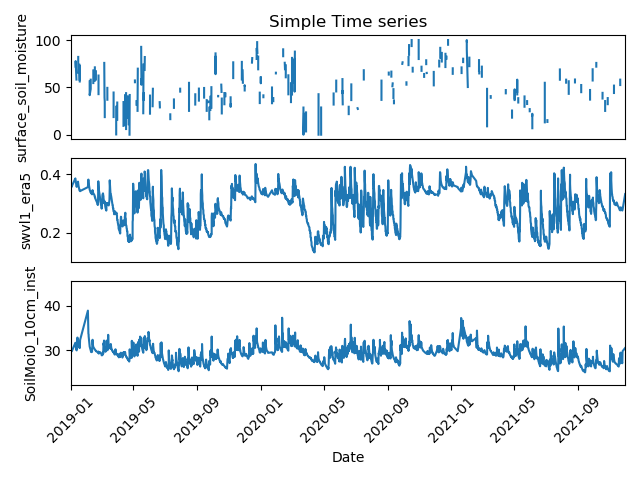

In [16]:
params = ["surface_soil_moisture", "swvl1_era5", "SoilMoi0_10cm_inst"]
timeperiod = [datetime(2019,1,1), datetime(2021,12,1)]
plot_ts(ts_valid, params, timeperiod, title="Simple Time series")